In [ ]:
%pip install kagglehub

In [13]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score



In [3]:
#importo il dataset da kagglehub
# Download latest version
path = kagglehub.dataset_download("alessiomasano/cifar10-hw3")

print("Path to dataset files:", path)


Path to dataset files: /home/codespace/.cache/kagglehub/datasets/alessiomasano/cifar10-hw3/versions/1


In [4]:
#leggo l'interno del dataset
cifar_hw3_path = path 
cifar_hw3_contents = os.listdir(cifar_hw3_path)
print("Contents of cifar_hw3:", cifar_hw3_contents)

Contents of cifar_hw3: ['cifar_hw3']


In [5]:
from sklearn.model_selection import train_test_split

#carico i dati di train e test
data_dir = os.path.join(cifar_hw3_path, "cifar_hw3")
x_train = np.load(os.path.join(data_dir, "x_train.npy"))
y_train = np.load(os.path.join(data_dir, "y_train.npy"))
x_test = np.load(os.path.join(data_dir, "x_test.npy"))
y_test = np.load(os.path.join(data_dir, "y_test.npy"))


# Assicurati che y_train sia 1D per lo split
y_train_flat = y_train.ravel()

# Split per ottenere 70% train, 15% validation, 15% test (test già separato)
x_train, x_validation, y_train, y_validation = train_test_split(
    x_train, y_train_flat, test_size=0.1765, random_state=42, stratify=y_train_flat
)



print(f"Shape of \n x_train: {x_train.shape} \n, y_train: {y_train.shape} \n, x_test: {x_test.shape} \n, y_test: {y_test.shape} \n, x_validation: {x_validation.shape} \n, y_validation: {y_validation.shape}")


Shape of 
 x_train: (32940, 32, 32, 3) 
, y_train: (32940,) 
, x_test: (10000, 32, 32, 3) 
, y_test: (10000, 1) 
, x_validation: (7060, 32, 32, 3) 
, y_validation: (7060,)


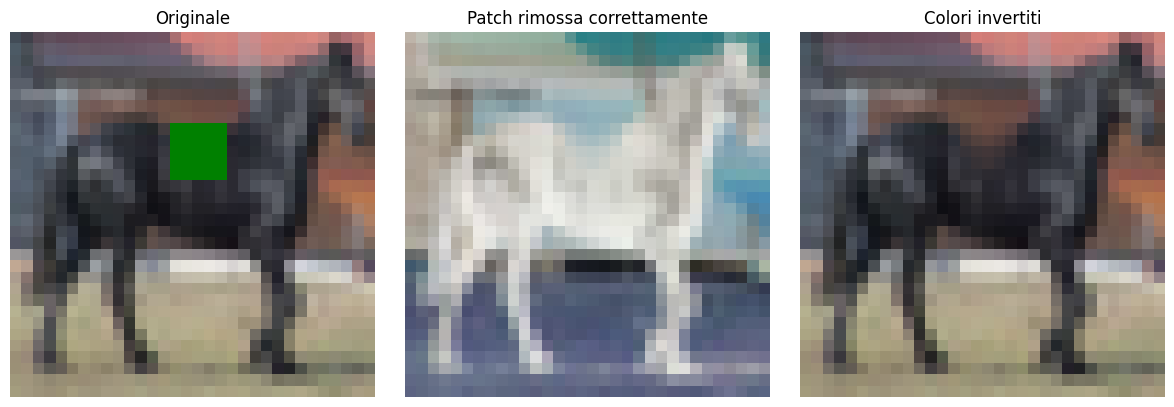

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def remove_uniform_patch_with_inpainting(img, patch_size=5, std_threshold=2.0):
    """
    Rileva blocchi a tinta uniforme (patch artificiali) ed esegue inpainting.
    """
    img_uint8 = (img * 255).astype(np.uint8)
    img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
    h, w, _ = img_bgr.shape

    mask = np.zeros((h, w), dtype=np.uint8)

    for r in range(0, h - patch_size + 1):
        for c in range(0, w - patch_size + 1):
            patch = img_bgr[r:r+patch_size, c:c+patch_size]
            std = np.std(patch, axis=(0,1))
            if np.mean(std) < std_threshold:
                mask[r:r+patch_size, c:c+patch_size] = 255

    # Applica inpainting
    inpainted_bgr = cv2.inpaint(img_bgr, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    # Converti in RGB e [0,1]
    inpainted_rgb = cv2.cvtColor(inpainted_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    return inpainted_rgb

# Filtro per inversione colori
def invert_colors(img_rgb_float):
    """
    Inverte i colori di un'immagine in formato RGB [0,1].
    """
    return 1.0 - img_rgb_float

# Test
i = 15
original_img = x_train[i]
patched_img = remove_uniform_patch_with_inpainting(original_img)

# Applica inversione colori
inverted_img = invert_colors(patched_img)

# Visualizza
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.title("Originale")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(patched_img)
plt.title("Patch rimossa correttamente")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(inverted_img)
plt.title("Colori invertiti")
plt.axis('off')

plt.tight_layout()
plt.show()

#Tramite l'uso di una liberira di OpenCV, che utilizza un metodo di inpainting, in  particolare Fast Marching Method, rimuovo le patch uniformi dalle immagini.
#Il risultato è un'immagine in cui le patch uniformi sono state rimosse e sostituite con una stima basata sui pixel circostanti, con colori invertiti.
#aggiungo un filtro di inversione ulteriore dell'immagine per migliorare la qualità visiva e trovo che il risultato sia molto buono.


In [7]:
def remove_uniform_patch_with_inpainting(img, patch_size=5, std_threshold=2.0):
    img_uint8 = (img * 255).astype(np.uint8)
    img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
    h, w, _ = img_bgr.shape
    mask = np.zeros((h, w), dtype=np.uint8)

    for r in range(0, h - patch_size + 1):
        for c in range(0, w - patch_size + 1):
            patch = img_bgr[r:r+patch_size, c:c+patch_size]
            std = np.std(patch, axis=(0,1))
            if np.mean(std) < std_threshold:
                mask[r:r+patch_size, c:c+patch_size] = 255

    inpainted_bgr = cv2.inpaint(img_bgr, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    inpainted_rgb = cv2.cvtColor(inpainted_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    # Inverti i colori
    inverted_rgb = 1.0 - inpainted_rgb
    return inverted_rgb


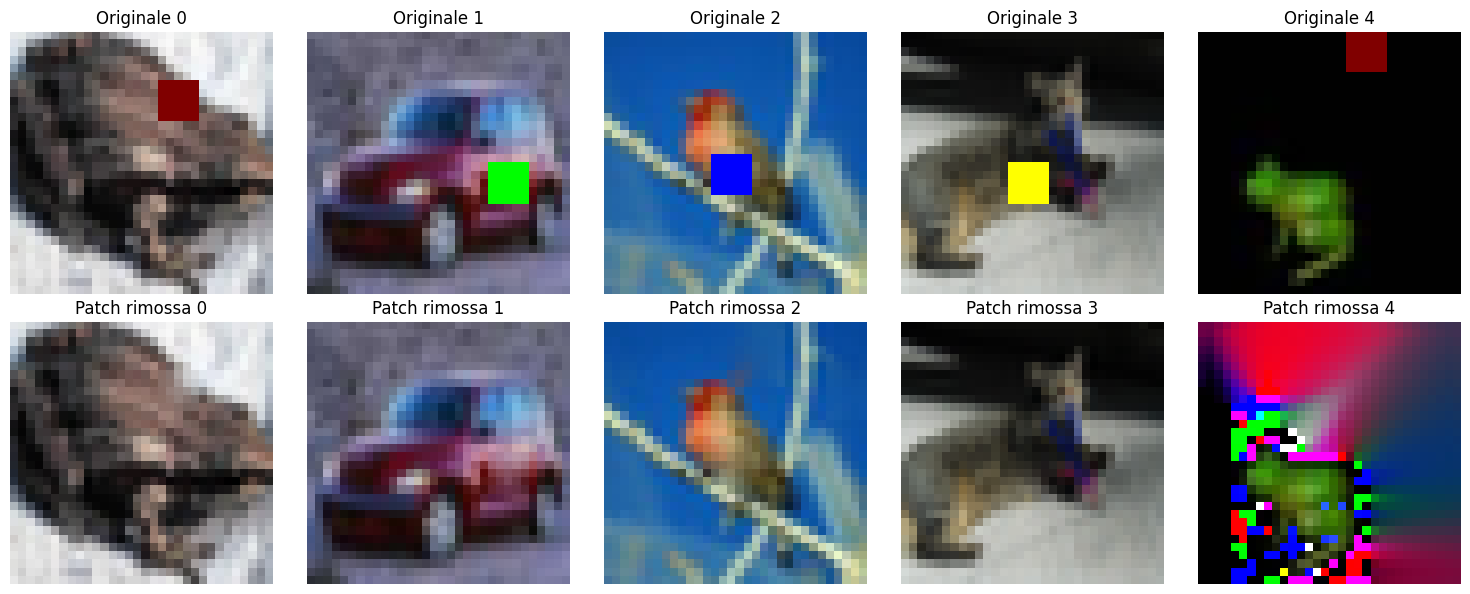

In [8]:
# Seleziona 5 immagini casuali da x_train
idx = np.random.choice(len(x_train), 5, replace=False)
sample_imgs = x_train[idx]

# Applica la funzione remove_uniform_patch_with_inpainting a ciascuna immagine
patched_imgs = [remove_uniform_patch_with_inpainting(img) for img in sample_imgs]

# Visualizza le immagini originali e quelle patchate
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axes[0, i].imshow(sample_imgs[i])
    axes[0, i].set_title(f"Originale {i}")
    axes[0, i].axis('off')
    axes[1, i].imshow(patched_imgs[i])
    axes[1, i].set_title(f"Patch rimossa {i}")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import cv2
import os
from tqdm import tqdm

# La tua funzione esistente
def remove_uniform_patch_with_inpainting(img, patch_size=5, std_threshold=2.0):
    img_uint8 = (img * 255).astype(np.uint8)
    img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_RGB2BGR)
    h, w, _ = img_bgr.shape
    mask = np.zeros((h, w), dtype=np.uint8)

    for r in range(0, h - patch_size + 1):
        for c in range(0, w - patch_size + 1):
            patch = img_bgr[r:r+patch_size, c:c+patch_size]
            std = np.std(patch, axis=(0,1))
            if np.mean(std) < std_threshold:
                mask[r:r+patch_size, c:c+patch_size] = 255

    inpainted_bgr = cv2.inpaint(img_bgr, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    inpainted_rgb = cv2.cvtColor(inpainted_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    # Inverti i colori
    inverted_rgb = 1.0 - inpainted_rgb
    return inverted_rgb

# === Carico i dati ===
data_dir = os.path.join(cifar_hw3_path, "cifar_hw3")
x_train = np.load(os.path.join(data_dir, "x_train.npy"))
y_train = np.load(os.path.join(data_dir, "y_train.npy"))
x_test = np.load(os.path.join(data_dir, "x_test.npy"))
y_test = np.load(os.path.join(data_dir, "y_test.npy"))

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

# === Processo x_train ===
print("\nPulizia x_train...")
x_train_clean = np.array([remove_uniform_patch_with_inpainting(img) for img in tqdm(x_train)])

# Salvo il risultato
np.save(os.path.join(data_dir, "x_train_clean.npy"), x_train_clean)
print("x_train_clean.npy salvato!")

# === Processo x_test ===
print("\nPulizia x_test...")
x_test_clean = np.array([remove_uniform_patch_with_inpainting(img) for img in tqdm(x_test)])

# Salvo il risultato
np.save(os.path.join(data_dir, "x_test_clean.npy"), x_test_clean)
print("x_test_clean.npy salvato!")


# Salva anche i dati puliti di test in un file locale


x_train shape: (40000, 32, 32, 3), y_train shape: (40000, 1)
x_test shape: (10000, 32, 32, 3), y_test shape: (10000, 1)

Pulizia x_train...


  0%|          | 170/40000 [00:02<11:04, 59.93it/s]

100%|██████████| 40000/40000 [10:35<00:00, 62.94it/s]


x_train_clean.npy salvato!

Pulizia x_test...


100%|██████████| 10000/10000 [02:38<00:00, 63.16it/s]


x_test_clean.npy salvato!

TUTTO FATTO 🚀


In [9]:
np.save("x_test_clean.npy", x_test_clean)
np.save("x_train_clean.npy", x_train_clean)

NameError: name 'x_test_clean' is not defined

In [9]:
x_train_clean = np.load(os.path.join(data_dir, "x_train_clean.npy"))
x_test_clean = np.load(os.path.join(data_dir, "x_test_clean.npy"))


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Carico anche le label
y_train = np.load(os.path.join(data_dir, "y_train.npy")).ravel()
y_test = np.load(os.path.join(data_dir, "y_test.npy")).ravel()

# Split validation set dal test set
# Esempio: 15% validation
x_test_clean_split, x_validation_clean, y_test_split, y_validation = train_test_split(
    x_test_clean, y_test, test_size=0.15, random_state=42, stratify=y_test
)

print(f"x_train_clean shape: {x_train_clean.shape}")
print(f"x_validation_clean shape: {x_validation_clean.shape}")
print(f"x_test_clean_split shape: {x_test_clean_split.shape}")

# Flatten immagini per MLP
x_train_flat = x_train_clean.reshape(x_train_clean.shape[0], -1)
x_validation_flat = x_validation_clean.reshape(x_validation_clean.shape[0], -1)
x_test_flat = x_test_clean_split.reshape(x_test_clean_split.shape[0], -1)

# Standardizzazione SOLO sul train
scaler = StandardScaler()
x_train_std = scaler.fit_transform(x_train_flat)
x_validation_std = scaler.transform(x_validation_flat)
x_test_std = scaler.transform(x_test_flat)

# PCA SOLO sul train
pca = PCA(n_components=0.95, random_state=42)
x_train_pca = pca.fit_transform(x_train_std)
x_validation_pca = pca.transform(x_validation_std)
x_test_pca = pca.transform(x_test_std)

# Check shapes
print(f"x_train_pca shape: {x_train_pca.shape}")
print(f"x_validation_pca shape: {x_validation_pca.shape}")
print(f"x_test_pca shape: {x_test_pca.shape}")


x_train_clean shape: (40000, 32, 32, 3)
x_validation_clean shape: (1500, 32, 32, 3)
x_test_clean_split shape: (8500, 32, 32, 3)
x_train_pca shape: (40000, 314)
x_validation_pca shape: (1500, 314)
x_test_pca shape: (8500, 314)


In [ ]:
# Parametri principali per MLPClassifier:
# - hidden_layer_sizes: tupla che rappresenta la struttura dell'MLP. Ogni elemento indica il numero di neuroni nel rispettivo layer.
#   Esempi:
#     hidden_layer_sizes = (100)        # un solo layer con 100 neuroni
#     hidden_layer_sizes = (100, 50)    # due layer: primo con 100 neuroni, secondo con 50
# - ✔️ max_iter: massimo numero di iteraazioni per la convergenza.
# - activation: funzione di attivazione ('relu', 'logistic', 'tanh', 'identity').
# - solver: algoritmo di ottimizzazione ('adam', 'sgd', 'lbfgs').
# - learning_rate_init: valore iniziale del learning rate.
# - ✔️ verbose: se True, stampa l'output di ogni iterazione di training.
# - ✔️ random_state: fissa il seed della randomizzazione.

# Esempio di MLP di base:
# hidden_layer_sizes = (100)
# max_iter = 20
# random_state = 42


Epoch 1/300 | Train Loss: 1.6542 | Val Loss: 1.7284 | Train Acc: 41.64% | Val Acc: 39.40%
Epoch 10/300 | Train Loss: 0.8921 | Val Loss: 1.6060 | Train Acc: 69.70% | Val Acc: 46.80%
Epoch 20/300 | Train Loss: 0.6631 | Val Loss: 2.0842 | Train Acc: 77.04% | Val Acc: 45.07%
Epoch 30/300 | Train Loss: 0.6394 | Val Loss: 2.6914 | Train Acc: 77.85% | Val Acc: 44.13%
Epoch 40/300 | Train Loss: 0.5869 | Val Loss: 3.2540 | Train Acc: 80.00% | Val Acc: 43.13%
Epoch 50/300 | Train Loss: 0.4672 | Val Loss: 3.6890 | Train Acc: 84.06% | Val Acc: 43.80%
Epoch 60/300 | Train Loss: 0.4057 | Val Loss: 4.0241 | Train Acc: 86.46% | Val Acc: 44.33%
Epoch 70/300 | Train Loss: 0.3638 | Val Loss: 4.4217 | Train Acc: 88.14% | Val Acc: 44.87%
Epoch 80/300 | Train Loss: 0.3339 | Val Loss: 4.7943 | Train Acc: 89.11% | Val Acc: 43.80%
Epoch 90/300 | Train Loss: 0.3502 | Val Loss: 5.1871 | Train Acc: 88.71% | Val Acc: 42.73%
Epoch 100/300 | Train Loss: 0.2785 | Val Loss: 5.3879 | Train Acc: 90.98% | Val Acc: 43.07%

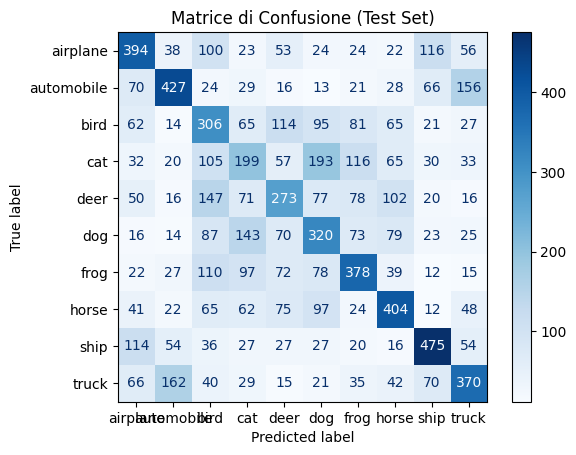


Metriche sul Test Set:
Precision: 41.90%
Recall:    41.72%
F1-score:  41.74%

Classification Report completo (per classe):
              precision    recall  f1-score   support

    airplane       0.45      0.46      0.46       850
  automobile       0.54      0.50      0.52       850
        bird       0.30      0.36      0.33       850
         cat       0.27      0.23      0.25       850
        deer       0.35      0.32      0.34       850
         dog       0.34      0.38      0.36       850
        frog       0.44      0.44      0.44       850
       horse       0.47      0.48      0.47       850
        ship       0.56      0.56      0.56       850
       truck       0.46      0.44      0.45       850

    accuracy                           0.42      8500
   macro avg       0.42      0.42      0.42      8500
weighted avg       0.42      0.42      0.42      8500



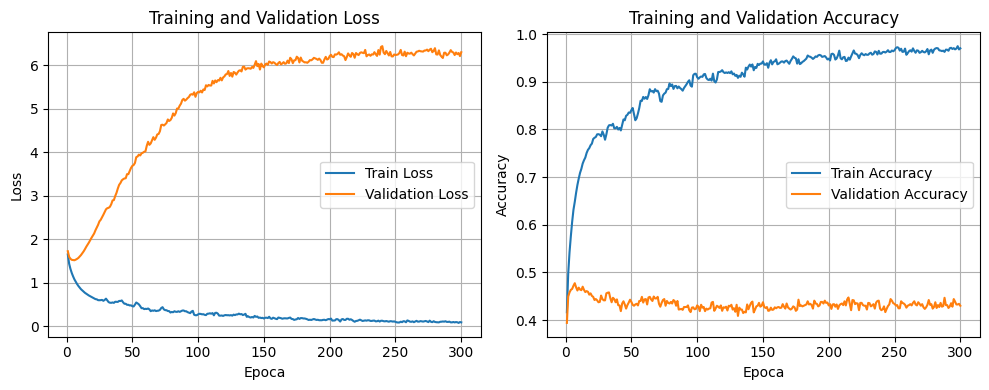


 Conclusione: 
Train set:    Accuracy = 97.03% | Loss = 0.0942
Validation:   Accuracy = 43.00% | Loss = 6.3000
Test set:     Accuracy = 41.72%


In [15]:
n_epochs = 300
train_losses1 = []  #lo utilizzo per plottare visto che MLPClassifier non ha un attributo loss_curve
val_losses1 = []
train_accuracies1 = []
val_accuracies1 = []


mlp1 = MLPClassifier(hidden_layer_sizes=(128, 64, 32),
                    alpha=0.01,  # regolarizzazione maggiore
                    max_iter=1,
                    warm_start=True,
                    random_state=42,
                    verbose=False,
                    solver='adam',
                    ) 



for epoch in range(n_epochs):
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    mlp1.fit(x_train_pca, y_train)

    # Predizioni probabilistiche e classi
    y_train_pred_proba1 = mlp1.predict_proba(x_train_pca)
    y_val_pred_proba1 = mlp1.predict_proba(x_validation_pca)
    y_train_pred1 = mlp1.predict(x_train_pca)
    y_val_pred1 = mlp1.predict(x_validation_pca)

    # Calcolo cross-entropy loss e accuracy
    train_loss1 = log_loss(y_train, y_train_pred_proba1)
    val_loss1 = log_loss(y_validation, y_val_pred_proba1)
    train_acc1 = accuracy_score(y_train, y_train_pred1)
    val_acc1 = accuracy_score(y_validation, y_val_pred1)

    train_losses1.append(train_loss1)
    val_losses1.append(val_loss1)
    train_accuracies1.append(train_acc1)
    val_accuracies1.append(val_acc1)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{n_epochs} | Train Loss: {train_loss1:.4f} | Val Loss: {val_loss1:.4f} | Train Acc: {train_acc1:.2%} | Val Acc: {val_acc1:.2%}")


# TEST finale
y_test_pred1 = mlp1.predict(x_test_pca)
test_acc1 = accuracy_score(y_test_split, y_test_pred1)
print(f"\n Accuracy finale su TEST set: {test_acc1:.2%}")

cifar10_labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]


# Matrice di confusione
cm = confusion_matrix(y_test_split, y_test_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cifar10_labels)
disp.plot(cmap='Blues')
plt.title("Matrice di Confusione (Test Set)")
plt.grid(False)
plt.show()

# Precision, Recall, F1-score
precision = precision_score(y_test_split, y_test_pred1, average='weighted')
recall = recall_score(y_test_split, y_test_pred1, average='weighted')
f1 = f1_score(y_test_split, y_test_pred1, average='weighted')

print(f"\nMetriche sul Test Set:")
print(f"Precision: {precision:.2%}")
print(f"Recall:    {recall:.2%}")
print(f"F1-score:  {f1:.2%}")

# Classification report completo (per classe)
print("\nClassification Report completo (per classe):")
print(classification_report(y_test_split, y_test_pred1, target_names=cifar10_labels))


# Plot LOSS
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses1, label='Train Loss')
plt.plot(range(1, n_epochs + 1), val_losses1, label='Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot ACCURACY
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_accuracies1, label='Train Accuracy')
plt.plot(range(1, n_epochs + 1), val_accuracies1, label='Validation Accuracy')
plt.xlabel('Epoca')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\n Conclusione: ")
print(f"Train set:    Accuracy = {train_accuracies1[-1]:.2%} | Loss = {train_losses1[-1]:.4f}")
print(f"Validation:   Accuracy = {val_accuracies1[-1]:.2%} | Loss = {val_losses1[-1]:.4f}")
print(f"Test set:     Accuracy = {test_acc1:.2%}")


In [ ]:
#Si nota un importante overfit in quanto la differenza tra training, validation e test è molto alta.

Epoch 1/300 | Train Loss: 3.2725 | Val Loss: 3.2390 | Train Acc: 14.77% | Val Acc: 14.53%
Epoch 10/300 | Train Loss: 2.0306 | Val Loss: 2.0492 | Train Acc: 26.32% | Val Acc: 24.80%
Epoch 20/300 | Train Loss: 1.8519 | Val Loss: 1.8957 | Train Acc: 33.00% | Val Acc: 30.33%
Epoch 30/300 | Train Loss: 1.7864 | Val Loss: 1.8420 | Train Acc: 35.39% | Val Acc: 33.47%
Epoch 40/300 | Train Loss: 1.7562 | Val Loss: 1.8170 | Train Acc: 36.69% | Val Acc: 34.20%
Epoch 50/300 | Train Loss: 1.7284 | Val Loss: 1.7962 | Train Acc: 37.69% | Val Acc: 35.13%
Epoch 60/300 | Train Loss: 1.6761 | Val Loss: 1.7597 | Train Acc: 39.79% | Val Acc: 36.93%
Epoch 70/300 | Train Loss: 1.6068 | Val Loss: 1.7113 | Train Acc: 42.75% | Val Acc: 39.80%
Epoch 80/300 | Train Loss: 1.5761 | Val Loss: 1.6925 | Train Acc: 43.82% | Val Acc: 40.13%
Epoch 90/300 | Train Loss: 1.5330 | Val Loss: 1.6698 | Train Acc: 45.46% | Val Acc: 42.13%
Epoch 100/300 | Train Loss: 1.5136 | Val Loss: 1.6594 | Train Acc: 46.17% | Val Acc: 42.93%

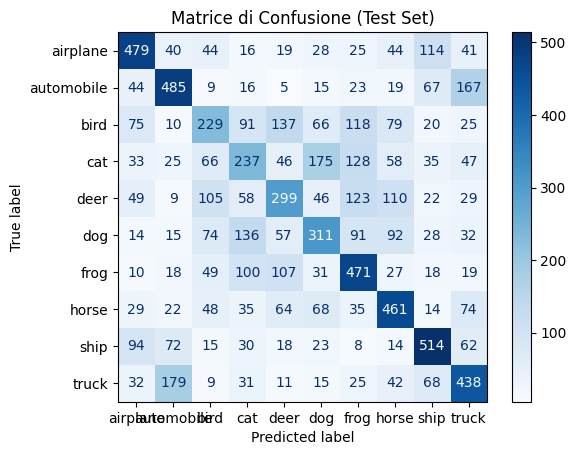


Metriche sul Test Set:
Precision: 45.50%
Recall:    46.16%
F1-score:  45.66%

Classification Report completo (per classe):
              precision    recall  f1-score   support

    airplane       0.56      0.56      0.56       850
  automobile       0.55      0.57      0.56       850
        bird       0.35      0.27      0.31       850
         cat       0.32      0.28      0.30       850
        deer       0.39      0.35      0.37       850
         dog       0.40      0.37      0.38       850
        frog       0.45      0.55      0.50       850
       horse       0.49      0.54      0.51       850
        ship       0.57      0.60      0.59       850
       truck       0.47      0.52      0.49       850

    accuracy                           0.46      8500
   macro avg       0.46      0.46      0.46      8500
weighted avg       0.46      0.46      0.46      8500



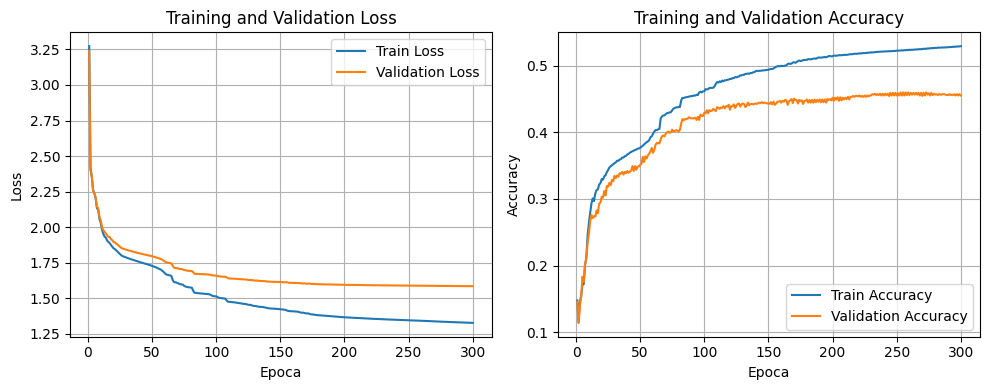


 Conclusione: 
Train set:    Accuracy = 52.94% | Loss = 1.3275
Validation:   Accuracy = 45.53% | Loss = 1.5851
Test set:     Accuracy = 46.16%


In [16]:
n_epochs = 300
train_losses = [] #lo utilizzo per plottare visto che MLPClassifier non ha un attributo loss_curve
val_losses = []
train_accuracies = []
val_accuracies = []

mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32),
                    alpha=0.001,
                    max_iter=1,
                    warm_start=True,
                    random_state=42,
                    verbose=False,
                    solver='lbfgs',)


for epoch in range(n_epochs):
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    mlp.fit(x_train_pca, y_train)

    # Predizioni probabilistiche e classi
    y_train_pred_proba = mlp.predict_proba(x_train_pca)
    y_val_pred_proba = mlp.predict_proba(x_validation_pca)
    y_train_pred = mlp.predict(x_train_pca)
    y_val_pred = mlp.predict(x_validation_pca)

    # Calcolo cross-entropy loss e accuracy
    train_loss = log_loss(y_train, y_train_pred_proba)
    val_loss = log_loss(y_validation, y_val_pred_proba)
    train_acc = accuracy_score(y_train, y_train_pred)
    val_acc = accuracy_score(y_validation, y_val_pred)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    #print di ogni 10 epoche
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1}/{n_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.2%} | Val Acc: {val_acc:.2%}")
      

# TEST finale
y_test_pred = mlp.predict(x_test_pca)
test_acc = accuracy_score(y_test_split, y_test_pred)
print(f"\n Accuracy finale su TEST set: {test_acc:.2%}")

cifar10_labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]


# Matrice di Confusione
cm = confusion_matrix(y_test_split, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cifar10_labels)
disp.plot(cmap='Blues')
plt.title("Matrice di Confusione (Test Set)")
plt.grid(False)
plt.show()

# Precision, Recall, F1-score (macro / weighted)
precision = precision_score(y_test_split, y_test_pred, average='weighted')
recall = recall_score(y_test_split, y_test_pred, average='weighted')
f1 = f1_score(y_test_split, y_test_pred, average='weighted')

print(f"\nMetriche sul Test Set:")
print(f"Precision: {precision:.2%}")
print(f"Recall:    {recall:.2%}")
print(f"F1-score:  {f1:.2%}")

# Classification report completo (per classe)
print("\nClassification Report completo (per classe):")
print(classification_report(y_test_split, y_test_pred, target_names=cifar10_labels))



# Plot LOSS
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot ACCURACY
plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, n_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoca')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\n Conclusione: ")
print(f"Train set:    Accuracy = {train_accuracies[-1]:.2%} | Loss = {train_losses[-1]:.4f}")
print(f"Validation:   Accuracy = {val_accuracies[-1]:.2%} | Loss = {val_losses[-1]:.4f}")
print(f"Test set:     Accuracy = {test_acc:.2%}")


In [ ]:
#Notiamo come l'overfit è stato quasi completamente eliminato, con una differenza minima tra training e validation.
#Tuttavia il test set risulta ancora poco accurato.
#C'è da considerare che il dataset è parecchio ridotto.

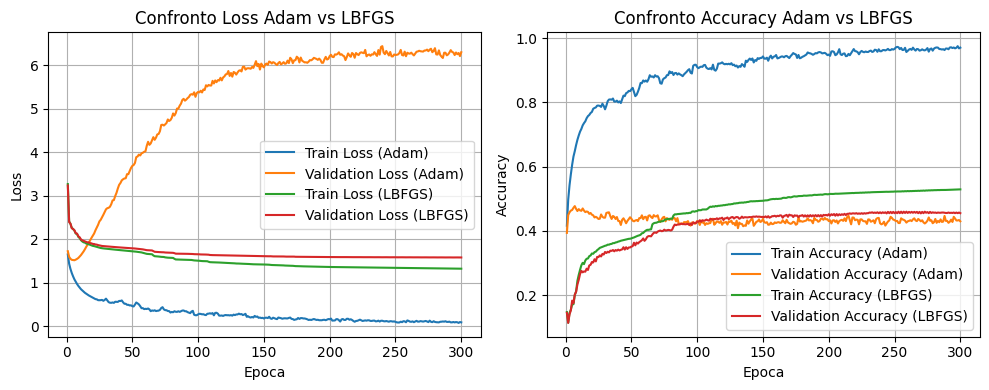


========== CONFRONTO FINALE ==========
Adam → Train Acc = 97.03% | Val Acc = 43.00% | Test Acc = 41.72%
LBFGS → Train Acc = 52.94% | Val Acc = 45.53% | Test Acc = 46.16%


In [17]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, n_epochs + 1), train_losses1, label='Train Loss (Adam)')
plt.plot(range(1, n_epochs + 1), val_losses1, label='Validation Loss (Adam)')
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss (LBFGS)')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss (LBFGS)')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.title('Confronto Loss Adam vs LBFGS')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, n_epochs + 1), train_accuracies1, label='Train Accuracy (Adam)')
plt.plot(range(1, n_epochs + 1), val_accuracies1, label='Validation Accuracy (Adam)')
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Train Accuracy (LBFGS)')
plt.plot(range(1, n_epochs + 1), val_accuracies, label='Validation Accuracy (LBFGS)')
plt.xlabel('Epoca')
plt.ylabel('Accuracy')
plt.title('Confronto Accuracy Adam vs LBFGS')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n========== CONFRONTO FINALE ==========")
print(f"Adam → Train Acc = {train_accuracies1[-1]:.2%} | Val Acc = {val_accuracies1[-1]:.2%} | Test Acc = {test_acc1:.2%}")
print(f"LBFGS → Train Acc = {train_accuracies[-1]:.2%} | Val Acc = {val_accuracies[-1]:.2%} | Test Acc = {test_acc:.2%}")
